In [10]:
from collections import namedtuple, defaultdict
from abc import ABC, abstractmethod
from random import choice
import math
import time

This is closely following https://gist.github.com/qpwo/c538c6f73727e254fdc7fab81024f6e1

In [11]:
class Node(ABC):
    '''Base class for nodes in the search tree. Should be subclassed for specific games. Represents the current state'''
    @abstractmethod
    def get_children(self):
        '''Returns a set of all child states of the current state by taking all actions available from the current state'''
        return set()

    @abstractmethod
    def get_random_child(self):
        '''Returns a random child state of the current state. Useful for efficient roll-outs'''
        return None

    @abstractmethod
    def is_terminal(self):
        '''Returns True if the current state is a terminal state'''
        return False

    @abstractmethod
    def get_reward(self):
        '''Returns the reward of the current state. Should only be called if the current state is a terminal state.'''
        return 0

    @abstractmethod
    def __hash__(self):
        '''Nodes must be hashable'''
        return 1234565789

    @abstractmethod
    def __eq__(self, other):
        '''Nodes must be comparable'''
        return True

I want to try this out on tic-tac-toe, an homage to the real OGs. 
I like the board representation from the git, so I'll use it.

A tic tac toe board is a 9-tuple of None, True, or False for empty, X, or O respectively.
E.g. 

O - -

\- X -

\- - X

would be 
(False, None, None, None, True, None, None, None, True)

Along those lines, player X is True and player O is False.

In [12]:
_TTTB = namedtuple('TTTB', "board_state player_to_move winner terminal")

class TicTacToeBoard(_TTTB, Node):
    def get_children(board):
        '''Return the new tic tac toe boards that result from taking all available actions in the board_state that are available to play in. The indices that are None in board_state.'''
        if board.is_terminal():
            return set()
        else:
            return {
                board.make_move(i) for i, val in enumerate(board.board_state) if val is None
            }
        
    def make_move(board, index):
        '''
        Makes a new tic tac toe board with the current player marking index
        This is where everything is calculated because this is where the new board object is created.
        '''
        if board.is_terminal():
            raise RuntimeError("You can't play on a terminal board state.")
        current_board_state = board.board_state
        if current_board_state[index] is not None:
            raise RuntimeError("You can't play there, that spot is already taken.")
        current_player = board.player_to_move
        new_board_state = current_board_state[:index]+(current_player,)+current_board_state[index+1:]
        next_player = not current_player
        winner = _find_winner(new_board_state)
        is_terminal = (winner is not None) or (None not in new_board_state) # Check if there is a winner or if the board is full
        return TicTacToeBoard(new_board_state, next_player, winner, is_terminal)
    
    def get_random_child(board):
        possible_actions = [i for i, val in enumerate(board.board_state) if val is None]
        chosen_action = choice(possible_actions)
        return board.make_move(chosen_action)
    
    def is_terminal(board):
        return board.terminal
        
    def get_reward(board):
        '''Only ever called on the agents's turn, aka, board.player_to_move should always be false.'''
        '''It is through backpropagation of the tree that we get a reward of one. See implementation of MCTS'''
        if not board.terminal:
            raise RuntimeError("Calling get_reward on a non-terminal board state.")
        if board.winner is board.player_to_move:
            raise RuntimeError("That's weird, how did you win on your opponent's turn?🤔")
        if board.player_to_move is (not board.winner):
            # Opponent wins
            return 0
        if board.winner is None:
            return 0.5
        raise RuntimeError("Wellp, something weird is happening. Here is the state of the game when you called get_reward"+board.to_pretty_string())
    
    def to_pretty_string(board):
        to_char = lambda v: ("X" if v is True else ("O" if v is False else " "))
        rows = [
            [to_char(board.board_state[3 * row + col]) for col in range(3)] for row in range(3)
        ]
        return (
            "\n Player to move: " + ("X" if board.player_to_move else "O") + "\n"
            "\n  1 2 3\n"
            + "\n".join(str(i + 1) + " " + " ".join(row) for i, row in enumerate(rows))
            + "\n"
        )

def _winning_combos():
    for start in range(0, 9, 3):  # three in a row
        yield (start, start + 1, start + 2)
    for start in range(3):  # three in a column
        yield (start, start + 3, start + 6)
    yield (0, 4, 8)  # down-right diagonal
    yield (2, 4, 6)  # down-left diagonal


def _find_winner(tup):
    "Returns None if no winner, True if X wins, False if O wins"
    for i1, i2, i3 in _winning_combos():
        v1, v2, v3 = tup[i1], tup[i2], tup[i3]
        if False is v1 is v2 is v3:
            return False
        if True is v1 is v2 is v3:
            return True
    return None


In [13]:
board = TicTacToeBoard(board_state=(None,)*9, player_to_move=True, winner=None, terminal=False)

In [14]:
print(board.to_pretty_string())
board = board.make_move(1)
print(board.to_pretty_string())


 Player to move: X

  1 2 3
1      
2      
3      


 Player to move: O

  1 2 3
1   X  
2      
3      



Now let's implement and understand the MCTS algorithm.

In [15]:
class MCTS:
    '''Monte-Carlo tree search implementation.'''
    def __init__(self, exploration_weight=1):
        self.total_rewards = defaultdict(int) #This will store the total reward at each node, tbh, Q is not a great name
        self.number_of_visits = defaultdict(int) # This will store the number of visits to each node
        self.children = dict() # This stores the children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node:Node):
        ''' Choose the best action available at the current node. PUCT, UCT, MCTS choice criterion'''
        if node.is_terminal():
            raise RuntimeError("The game is over, no further actions can be taken.")
        if node not in self.children:
            return node.get_random_child()
        
        def score(n:Node):
            '''
            This is the most basic implementation of MCTS that just exploits and doesn't balance exploitation and exploration(e.g. UCT).
            score = $\frac{total_rewards[n]}{number_of_visits[n]}$
            '''
            if self.number_of_visits[n] == 0:
                return float("-inf") # unseen state
            return self.total_rewards[n]/self.number_of_visits[n]
        
        return max(self.children[node], key=score)
    
    def do_rollout(self, node:Node):
        '''MCTS rollout algorithm'''
        path = self._select(node) # first select an unexplored node
        unexplored_node = path[-1]
        self._expand(unexplored_node)
        reward = self._simulate(unexplored_node)
        self._backpropagate(path, reward)

    def _select(self, node:Node):
        '''Find an unexplored child of node'''
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path # node will be in self.children if it has been explored, and if self.children[node] is empty, not self.children[node] is True
            unexplored = self.children[node] - self.children.keys() # children available to explore minus the children that have already been explored
            if unexplored:
                next_node = unexplored.pop()
                path.append(next_node)
                return path
            node = self._uct_select(node)
        
    def _expand(self, node:Node):
        '''Add node to the self.children dictionary'''
        if node in self.children:
            return
        self.children[node] = node.get_children()

    def _simulate(self, node:Node):
        '''Returns the reward for a random simulation of the game from node'''
        reward = 0 # we are always simulating from a reset state
        while True:
            reward += node.get_reward()
            if node.is_terminal():
                return reward
            node = node.get_random_child()

    def _backpropagate(self, path, reward):
        '''Propagates reward backwards through ancestor nodes'''
        for node in reversed(path):
            self.number_of_visits[node] +=1
            self.total_rewards[node] += reward

    def _uct_select(self, node:Node):
        # Every child of this node must be expanded
        assert all(n in self.children for n in self.children[node])

        log_number_of_visits_vertex = math.log(self.number_of_visits[node])

        def uct(n:Node):
            return self.total_rewards[n]/self.number_of_visits[n] + self.exploration_weight * math.sqrt(log_number_of_visits_vertex/self.number_of_visits[n])
        
        return max(self.children[node], key=uct)


In [16]:

def new_tic_tac_toe_board():
    return TicTacToeBoard(board_state=(None,) * 9, player_to_move=True, winner=None, terminal=False)


In [17]:
def play_game(number_of_games=100, agent_A_rollouts=5, agent_B_rollouts=5, human_input=False, slow_time=False, print_games=False, print_intermediate_info=False):
    A_wins = 0
    B_wins = 0
    ties = 0
    treeA = MCTS()
    treeB = MCTS()

    for i in range(number_of_games):
        board = new_tic_tac_toe_board()
        if print_games:print(board.to_pretty_string())
        while True:
            if human_input:
                row_col = input("enter row,col: ")
                row, col = map(int, row_col.split(","))
                index = 3 * (row - 1) + (col - 1)
                board = board.make_move(index)
            else:
                for _ in range(agent_A_rollouts):
                    treeA.do_rollout(board)
                board = treeA.choose(board)
            if print_games: print(board.to_pretty_string())
            if board.terminal:
                if board.winner is None:
                    ties+=1
                else: 
                    A_wins+=1
                break
            if slow_time: time.sleep(1)
            # You can train as you go, or only at the beginning.
            # Here, we train as we go, doing fifty rollouts each turn.
            for _ in range(agent_B_rollouts):
                treeB.do_rollout(board)
            board = treeB.choose(board)
            if print_games: print(board.to_pretty_string())
            if board.terminal:
                if board.winner is None:
                    ties+=1
                else:
                    B_wins+=1
                break
            if slow_time: time.sleep(1)
        if print_intermediate_info: print(f"Game {i+1} over. A_wins: {A_wins}, B_wins: {B_wins}, ties: {ties}")

    print(f"Player A won {A_wins} times, Player B won {B_wins} times, and there were {ties} ties.")
    return A_wins, B_wins, ties


In [18]:
Aw, Bw, t = play_game()

RuntimeError: Calling get_reward on a non-terminal board state.

In [19]:
A_rollouts = 5
B_rollouts = range(5, 25)
num_trials = 5
A_wins = defaultdict(list)
B_wins = defaultdict(list)
ties = defaultdict(list)
for B_rollout in B_rollouts:
    for trial in range(num_trials):
        Aw, Bw, t = play_game(agent_A_rollouts=A_rollouts, agent_B_rollouts=B_rollout, print_games=False, number_of_games=50)
        A_wins[B_rollout].append(Aw)
        B_wins[B_rollout].append(Bw)
        ties[B_rollout].append(t)

RuntimeError: Calling get_reward on a non-terminal board state.

In [20]:
import matplotlib.pyplot as plt
import numpy as np


c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


StopIteration: 

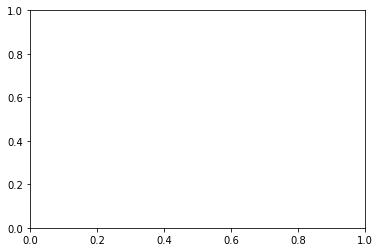

In [21]:
A_win_ave = [sum(A_wins[B_rollout])/num_trials for B_rollout in B_rollouts]
B_win_ave = [sum(B_wins[B_rollout])/num_trials for B_rollout in B_rollouts]
tie_ave = [sum(ties[B_rollout])/num_trials for B_rollout in B_rollouts]
A_win_var = [np.var(A_wins[B_rollout])**0.5 for B_rollout in B_rollouts]
B_win_var = [np.var(B_wins[B_rollout])**0.5 for B_rollout in B_rollouts]
tie_var = [np.var(ties[B_rollout])**0.5 for B_rollout in B_rollouts]

plt.errorbar(B_rollouts, A_win_ave, yerr=A_win_var, label="A wins", capsize=3)
plt.errorbar(B_rollouts, B_win_ave, yerr=B_win_var, label="B wins", capsize=3)
plt.errorbar(B_rollouts, tie_ave, yerr=tie_var, label="ties", capsize=3)
plt.legend()
plt.show()

In [25]:
import gymnasium as gym
from copy import deepcopy

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
env = gym.make("CartPole-v1", render_mode="human")
env.reset()
env.render()

Let's play with cartpole first.
display the cartpole html page here
<iframe
  src="https://www.gymlibrary.dev/environments/classic_control/cart_pole/"
  scrolling="yes"
  style="width:100%;"
></iframe>

In [27]:
from IPython.display import IFrame

IFrame(src="https://gymnasium.farama.org/environments/classic_control/cart_pole/", width=1200, height=600)

In [28]:
for _ in range(1000):
    obs, reward, done, truncated, info = env.step(env.action_space.sample())
    print(obs, reward, done, truncated, info)
    env.render()
    if done:
        break


[-0.04715811  0.20874114  0.04903005 -0.3072619 ] 1.0 False False {}
[-0.04298329  0.4031314   0.04288481 -0.58408785] 1.0 False False {}
[-0.03492067  0.20743577  0.03120306 -0.27820998] 1.0 False False {}
[-0.03077195  0.402099    0.02563886 -0.5608905 ] 1.0 False False {}
[-0.02272997  0.59685194  0.01442104 -0.84538686] 1.0 False False {}
[-0.01079293  0.79177415 -0.00248669 -1.1335002 ] 1.0 False False {}
[ 0.00504255  0.9869286  -0.0251567  -1.426962  ] 1.0 False False {}
[ 0.02478112  0.7921263  -0.05369594 -1.1422464 ] 1.0 False False {}
[ 0.04062365  0.5977456  -0.07654087 -0.8668745 ] 1.0 False False {}
[ 0.05257856  0.79382104 -0.09387835 -1.1826077 ] 1.0 False False {}
[ 0.06845498  0.60003424 -0.1175305  -0.92076707] 1.0 False False {}
[ 0.08045567  0.79653156 -0.13594584 -1.2479542 ] 1.0 False False {}
[ 0.0963863   0.99310917 -0.16090493 -1.5799451 ] 1.0 False False {}
[ 0.11624848  0.8002273  -0.19250384 -1.3414617 ] 1.0 False False {}
[ 0.13225302  0.997179   -0.219333

Let's start by writing a function that takes an observation [cart_x, cart_v, pole_theta, pole_v] and returns a discretized state

In [29]:
cart_x_bins = np.linspace(-2.4, 2.4, 100)
cart_v_bins = np.linspace(-5, 5, 100)
pole_theta_bins = np.linspace(-0.22, 0.22, 100)
pole_v_bins = np.linspace(-5, 5, 100)

total_num_states = len(cart_x_bins) * len(cart_v_bins) * len(pole_theta_bins) * len(pole_v_bins)

def discretize(observation):
    cart_x, cart_v, pole_theta, pole_v = observation
    cart_x = np.digitize(cart_x, cart_x_bins)
    cart_v = np.digitize(cart_v, cart_v_bins)
    pole_theta = np.digitize(pole_theta, pole_theta_bins)
    pole_v = np.digitize(pole_v, pole_v_bins)
    return cart_x, cart_v, pole_theta, pole_v

print(total_num_states)

100000000


In [30]:
print(obs, discretize(obs))

[ 0.13225302  0.997179   -0.21933307 -1.6876794 ] (53, 60, 1, 33)


In [35]:
_CartPole = namedtuple("_CartPole", ["cart_x", "cart_v", "pole_theta", "pole_v", "done"])

class CartPole(_CartPole, Node):
    '''Node representation of a cart pole environment.'''
    def get_children(cart_pole):
        if cart_pole.done:
            env.reset()
            return set()
        else:
            return {cart_pole.make_move(0), cart_pole.make_move(1)}
        
    def make_move(cart_pole, index):
        obs, reward, done, truncated, info = env.step(index)
        cart_x, cart_v, pole_theta, pole_v = discretize(obs)
        if done:
            print("done")
        return CartPole(cart_x, cart_v, pole_theta, pole_v, done)
    
    def get_random_child(cart_pole):
        return cart_pole.make_move(env.action_space.sample())
    
    def is_terminal(cart_pole):
        return cart_pole.done
    
    def render(cart_pole):
        env.render()

In [36]:
def play_cartpole():
    trial_rewards=[]
    tree = MCTS()
    # training
    for trials in range(1000):
        print(f"{trials=}")
        for _ in range(5):
            obs, _= env.reset(seed=42)
            obs = discretize(obs)
            cartpole = CartPole(*obs, False)
            tree.do_rollout(cartpole)

        
       
        if trials%10==0:
            print(f"trial {trials}")
            obs, _ = env.reset(seed=42)
            obs = discretize(obs)
            cartpole = CartPole(*obs, False)
            time_step=0
            while not cartpole.done:
                old_cartpole=cartpole
                cartpole = tree.choose(cartpole)
                cartpole.render()
                time_step+=1
            print(f"reward: {time_step}")
            print(f"reward, number of visits: {tree.total_rewards[old_cartpole]}, {tree.number_of_visits[old_cartpole]}")
            trial_rewards.append(time_step)
    
    return trial_rewards

In [37]:

rew = play_cartpole()

trials=0
done
done
done


KeyboardInterrupt: 

[81, 12, 31, 14, 25, 18, 10, 2, 2, 2]


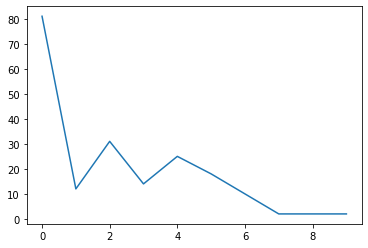

In [ ]:
plt.plot(range(len(rew)), rew)
print(rew)